<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

# TFM - Sistema de alerta ante la presencia de Didymosphenia Geminata en agua dulce con técnicas de inteligencia artificial

Presentado por: Aracena Vallejos, Estefania – Medina Jiménez, Lenin  
Directora: Prados Privado, María

## Redes Neuronales para Grafos - Grafo 1

El objetivo es implementar un modelo de predicción del crecimiento de Didymo en los sistemas hídricos de Chile, empleando  técnicas aprendizaje semi supervisado utilizando el método de Redes Neuronales de Perceptron y Convolucionales.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from collections import Counter
import networkx as nx
import warnings

In [2]:
#Carga de datos
didymo_df = pd.read_csv('data.csv', sep = ';')
didymo_df.rename(columns={'Unnamed: 0': "id"}, inplace=True)
didymo_df

,id,T°,categoria,pH,Ce,TDS,OD,%Sat. O,Ca,PO4,...,Crec_algal_Inicial,Crec_algal_Mediana,Crec_algal_Alta,Crec_algal_Muy Alta,%Cob_algal_ausente,%Cob_algal_Pequenas colonias,%Cob_algal_Mediana,%Cob_algal_Alta,%Cob_algal_Muy Alta,Didymo
0,0,14.8,%Cob_algal_Alta,8.2,80.0,40.0,11.8,118.4,7.9,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
1,1,15.6,%Cob_algal_Alta,6.7,73.0,36.0,12.2,124.2,9.2,1.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
2,2,11.1,%Cob_algal_Alta,7.1,152.0,76.0,10.0,101.5,5.5,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
3,3,15.2,%Cob_algal_Alta,7.8,82.0,13.8,11.8,111.8,4.2,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
4,4,13.9,%Cob_algal_Muy Alta,7.4,31.0,15.0,10.4,102.3,4.5,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,1600,6.0,%Cob_algal_Mediana,7.5,44.0,22.0,18.8,117.3,8.3,0.151,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.51
1601,1601,13.5,%Cob_algal_Muy Alta,7.5,49.0,25.0,11.4,109.7,6.0,0.001,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
1602,1602,11.7,%Cob_algal_Alta,7.4,74.0,37.0,11.3,105.9,5.3,0.001,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
1603,1603,7.0,%Cob_algal_Alta,7.4,39.0,19.0,13.3,118.4,8.3,0.151,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.51


In [3]:
didymo_df.columns

Index(['id', 'T°', 'categoria', 'pH', 'Ce', 'TDS', 'OD', '%Sat. O', 'Ca',
       'PO4', 'P T', 'Fe', 'NO3', 'NO2', 'NT', 'NKT', 'Si T', 'Turbidez',
       'prof_m', 'vel_0.2_m', 'vel_0.6_m', 'vel_0.8_m', 'Crec_algal_Ausente',
       'Crec_algal_Inicial', 'Crec_algal_Mediana', 'Crec_algal_Alta',
       'Crec_algal_Muy Alta', '%Cob_algal_ausente',
       '%Cob_algal_Pequenas colonias', '%Cob_algal_Mediana', '%Cob_algal_Alta',
       '%Cob_algal_Muy Alta', 'Didymo'],
      dtype='object')

In [4]:
max(didymo_df['id'].value_counts())

1

In [5]:
atributos = ['T°', 'pH', 'Ce', 'TDS', 'OD', '%Sat. O', 'Ca', 'PO4', 'P T', 'Fe', 'NO3', 'NO2', 'NT', 'NKT', 'Si T', 'Turbidez', 'Didymo']
edges = ['Crec_algal_Ausente', 'Crec_algal_Inicial', 'Crec_algal_Mediana', 'Crec_algal_Alta', 'Crec_algal_Muy Alta']

In [6]:
# Sort to define the order of nodes
sorted_df = didymo_df.sort_values(by="id")
# Select node features
node_features = sorted_df[atributos]
node_features.head() 

,T°,pH,Ce,TDS,OD,%Sat. O,Ca,PO4,P T,Fe,NO3,NO2,NT,NKT,Si T,Turbidez,Didymo
0,14.8,8.2,80.0,40.0,11.8,118.4,7.9,1.0,0.6,0.021,0.2,0.1,2.9,2.9,1.0,0.7,0.0
1,15.6,6.7,73.0,36.0,12.2,124.2,9.2,1.0,0.7,0.021,0.2,0.1,4.6,4.6,21.5,0.2,0.0
2,11.1,7.1,152.0,76.0,10.0,101.5,5.5,1.0,0.2,0.021,0.2,0.1,1.9,1.9,22.7,0.2,0.0
3,15.2,7.8,82.0,13.8,11.8,111.8,4.2,1.0,1.0,0.021,0.2,0.1,2.0,2.0,14.9,0.3,0.0
4,13.9,7.4,31.0,15.0,10.4,102.3,4.5,1.0,0.2,0.021,0.2,0.1,2.0,2.0,9.0,0.6,0.0


In [7]:
# Convert to numpy
x = node_features.to_numpy()
x = torch.tensor(x) 
x.shape # [num_nodes x num_features]

torch.Size([1605, 17])

In [8]:
etiquetas = didymo_df['categoria']
# etiquetas de las conexiones del grafo (encoding) en formato tensor
labels = torch.tensor(etiquetas.astype("category").cat.codes.to_numpy())
y = labels
y.shape

torch.Size([1605])

In [9]:
#conexiones del grafo, relación de todos los nodos con todos
catego = didymo_df['categoria'].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
for categor in catego:
    catego_df = didymo_df[didymo_df['categoria'] == categor]
    id_didymo = didymo_df['id'].values
    # crea todas las conexiones 
    permutations = list(itertools.combinations(id_didymo, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    catego_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, catego_edges])
edge_index = all_edges.transpose()
edge_index1 = torch.tensor(edge_index, dtype=torch.long)
print(edge_index1)

tensor([[   0,    0,    0,  ..., 1602, 1602, 1603],
        [   1,    2,    3,  ..., 1603, 1604, 1604]])


In [10]:

data_list = [Data(...), ..., Data(...)]
loader = DataLoader(data_list, batch_size=32)
data = Data(x=x, edge_index=edge_index1, y=y)
networkX_graph = to_networkx(data)
data

Data(x=[1605, 17], edge_index=[2, 6436050], y=[1605])

In [11]:
#Establecer el tipo de datos en x: matriz de atributos, y: etiquetas
data.x = data.x.to(torch.float)
data.y = data.y.type(torch.LongTensor)

In [12]:
#Resumen
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 1605
Number of edges: 6436050
Average node degree: 4010.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [13]:
#nx.draw(networkX_graph)

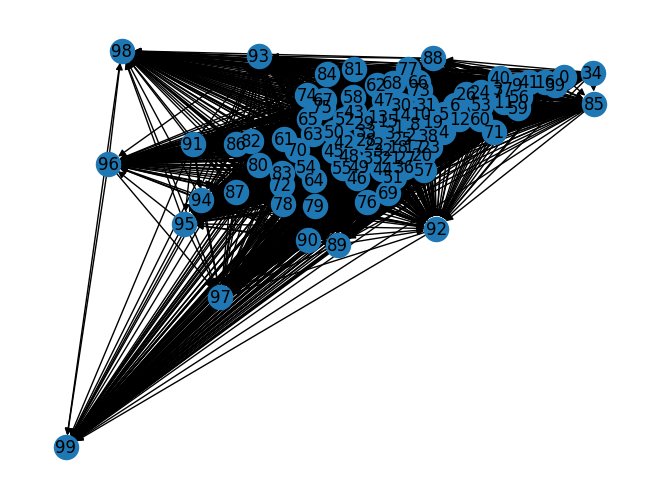

In [14]:
subgraph = networkX_graph.subgraph(range(100))
pos = nx.spring_layout(subgraph)
grafo1 = nx.draw(subgraph, pos, with_labels=True)
grafo1

In [15]:
#División datos de entrenamiento, prueba y validación
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(data)
graph

Data(x=[1605, 17], edge_index=[2, 6436050], y=[1605], train_mask=[1605], val_mask=[1605], test_mask=[1605])

In [16]:
#Contador de nodos por cada categoría
sorted(Counter(graph.y.tolist()).items())

[(0, 396), (1, 292), (2, 373), (3, 259), (4, 285)]

In [17]:
dataset = graph
num_classes = len(torch.unique(graph.y))
print('Número de clases: ', num_classes)

Número de clases:  5


In [18]:
#creación y armado de la red perceptron
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 96),
        nn.ReLU(),
        nn.Linear(96, 96),
        nn.ReLU(),
        nn.Linear(96, 96),
        nn.ReLU(),
        nn.Linear(96, 96),
        nn.ReLU(),
        nn.Linear(96, 96),
        nn.ReLU(),
        #nn.Linear(96, 96),
        #nn.ReLU(),
        nn.Linear(96, 96),
        nn.ReLU(),
        nn.Linear(96, num_classes)
        )
#armado del modelo
    def forward(self, data):
        x = data.x  
        output = self.layers(x)
        return output

#entrenamiento y validación 
mlp = MLP()
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [19]:
#creación red neuronal convolucional 

#creación de cada capa
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 8)
        self.conv2 = GCNConv(8, 8)
        self.conv4 = GCNConv(8, 8)
        self.conv3 = GCNConv(8, num_classes)
#armado de la red y modelo
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        output = self.conv3(x, edge_index)
        return output
    
#entrenamiento y validación    
gcn = GCN()
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [20]:
#creación red neuronal convolucional normalizada

#creación de cada capa
class GCNNorm(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 8)
        self.conv2 = GCNConv(8, 8)
        self.conv4 = GCNConv(8, 8)
        self.conv5 = GCNConv(8, 8)
        self.conv3 = GCNConv(8, num_classes)
        self.convN1 = BatchNorm(dataset.num_node_features)
        

#armado de la red y modelo
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.convN1(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        output = self.conv3(x, edge_index)

        return output
    
#entrenamiento y validación    
gcnNorm = GCNNorm()
optimizer_gcn_norm = torch.optim.Adam(gcnNorm.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [21]:

def train_node_classifier(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(graph)
    loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test_node_classifier(model, optimizer):
    model.eval()
    pred = model(graph).argmax(dim=1)
    test_acc = accuracy_score(graph.y[graph.test_mask].numpy(), pred[graph.test_mask].numpy())
    return test_acc

def eval_node_classifier(model, graph, mask):
    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

Epoch: 010, Loss: 1.5922, Test Accuracy: 0.2710
Epoch: 020, Loss: 1.5774, Test Accuracy: 0.2897
Epoch: 030, Loss: 1.5709, Test Accuracy: 0.2835
Epoch: 040, Loss: 1.5583, Test Accuracy: 0.2866
Epoch: 050, Loss: 1.5419, Test Accuracy: 0.2960
Epoch: 060, Loss: 1.5322, Test Accuracy: 0.3022
Epoch: 070, Loss: 1.5171, Test Accuracy: 0.3022
Epoch: 080, Loss: 1.4879, Test Accuracy: 0.2741
Epoch: 090, Loss: 1.4887, Test Accuracy: 0.2835
Epoch: 100, Loss: 1.4633, Test Accuracy: 0.2430
Epoch: 110, Loss: 1.5094, Test Accuracy: 0.2679
Epoch: 120, Loss: 1.4697, Test Accuracy: 0.2928
Epoch: 130, Loss: 1.4617, Test Accuracy: 0.2773
Epoch: 140, Loss: 1.4310, Test Accuracy: 0.2430
Epoch: 150, Loss: 1.3847, Test Accuracy: 0.2866
Epoch: 160, Loss: 1.3846, Test Accuracy: 0.2648
Epoch: 170, Loss: 1.4232, Test Accuracy: 0.3115
Epoch: 180, Loss: 1.3585, Test Accuracy: 0.3084
Epoch: 190, Loss: 1.3111, Test Accuracy: 0.2960
Epoch: 200, Loss: 1.3415, Test Accuracy: 0.2773
Epoch: 210, Loss: 1.2686, Test Accuracy:

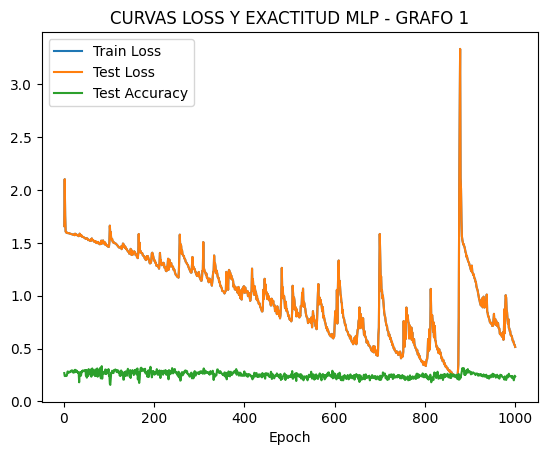

In [22]:
num_epochs = 1000
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train_node_classifier(mlp, optimizer_mlp)
    test_acc = test_node_classifier(mlp, optimizer_mlp)

    train_losses.append(loss.item())
    test_losses.append(loss.item())
    test_accuracies.append(test_acc)

    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

test_acc1 = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc1:.3f}')

# Plotting
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('CURVAS LOSS Y EXACTITUD MLP - GRAFO 1')
plt.savefig('mlp-todos.jpg')
plt.show()

Epoch: 010, Loss: 9.7424, Test Accuracy: 0.2835
Epoch: 020, Loss: 13.4385, Test Accuracy: 0.1682
Epoch: 030, Loss: 3.8816, Test Accuracy: 0.2368
Epoch: 040, Loss: 2.0587, Test Accuracy: 0.2804
Epoch: 050, Loss: 1.9306, Test Accuracy: 0.2617
Epoch: 060, Loss: 1.7837, Test Accuracy: 0.2835
Epoch: 070, Loss: 1.7137, Test Accuracy: 0.2835
Epoch: 080, Loss: 2.1048, Test Accuracy: 0.2835
Epoch: 090, Loss: 1.6209, Test Accuracy: 0.2336
Epoch: 100, Loss: 1.7361, Test Accuracy: 0.3022
Epoch: 110, Loss: 1.6380, Test Accuracy: 0.2991
Epoch: 120, Loss: 1.6198, Test Accuracy: 0.2679
Epoch: 130, Loss: 1.5948, Test Accuracy: 0.2617
Epoch: 140, Loss: 1.5945, Test Accuracy: 0.2991
Epoch: 150, Loss: 1.5909, Test Accuracy: 0.2991
Epoch: 160, Loss: 1.5895, Test Accuracy: 0.3022
Epoch: 170, Loss: 1.5885, Test Accuracy: 0.3053
Epoch: 180, Loss: 1.5875, Test Accuracy: 0.3053
Epoch: 190, Loss: 1.5867, Test Accuracy: 0.3053
Epoch: 200, Loss: 1.5859, Test Accuracy: 0.3084
Epoch: 210, Loss: 1.5852, Test Accuracy

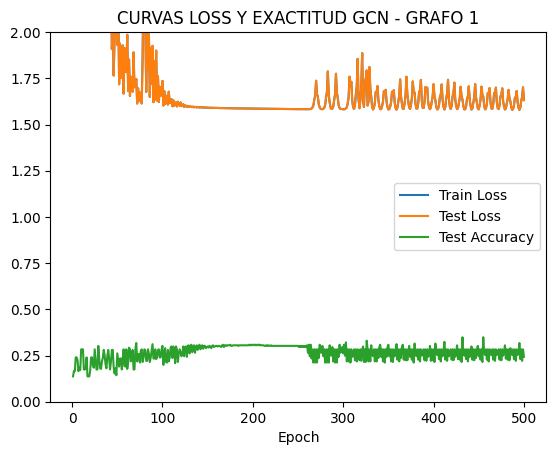

In [23]:
num_epochs = 500
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train_node_classifier(gcn, optimizer_gcn)
    test_acc = test_node_classifier(gcn, optimizer_gcn)

    train_losses.append(loss.item())
    test_losses.append(loss.item())
    test_accuracies.append(test_acc)

    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

test_acc2 = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc2:.3f}')

# Plotting
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.ylim([0.0, 2])
plt.xlabel('Epoch')
plt.legend()
plt.title('CURVAS LOSS Y EXACTITUD GCN - GRAFO 1')
plt.savefig('gcn-todos.jpg')
plt.show()

Epoch: 010, Loss: 1.7298, Test Accuracy: 0.2835
Epoch: 020, Loss: 1.6193, Test Accuracy: 0.2804
Epoch: 030, Loss: 1.6084, Test Accuracy: 0.2399
Epoch: 040, Loss: 1.6067, Test Accuracy: 0.2399
Epoch: 050, Loss: 1.5988, Test Accuracy: 0.2399
Epoch: 060, Loss: 1.5958, Test Accuracy: 0.2461
Epoch: 070, Loss: 1.5910, Test Accuracy: 0.2835
Epoch: 080, Loss: 1.5868, Test Accuracy: 0.2617
Epoch: 090, Loss: 1.5843, Test Accuracy: 0.2960
Epoch: 100, Loss: 1.5828, Test Accuracy: 0.2773
Epoch: 110, Loss: 1.5816, Test Accuracy: 0.2710
Epoch: 120, Loss: 1.5807, Test Accuracy: 0.2773
Epoch: 130, Loss: 1.5786, Test Accuracy: 0.2804
Epoch: 140, Loss: 1.5756, Test Accuracy: 0.2710
Epoch: 150, Loss: 1.5727, Test Accuracy: 0.2741
Epoch: 160, Loss: 1.5682, Test Accuracy: 0.2648
Epoch: 170, Loss: 1.5670, Test Accuracy: 0.2866
Epoch: 180, Loss: 1.5591, Test Accuracy: 0.2492
Epoch: 190, Loss: 1.5545, Test Accuracy: 0.2555
Epoch: 200, Loss: 1.5514, Test Accuracy: 0.2617
Epoch: 210, Loss: 1.5486, Test Accuracy:

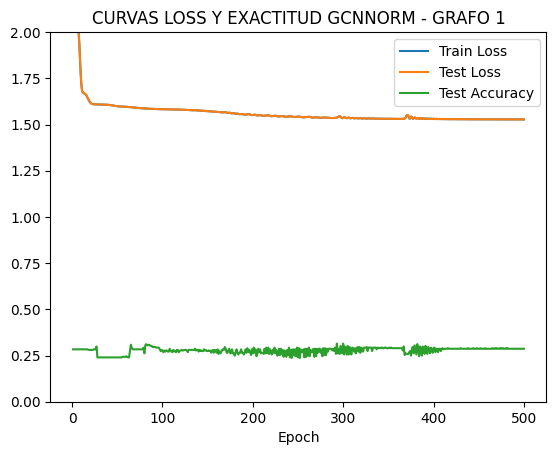

In [24]:
num_epochs = 500
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    loss = train_node_classifier(gcnNorm, optimizer_gcn_norm)
    test_acc = test_node_classifier(gcnNorm, optimizer_gcn_norm)

    train_losses.append(loss.item())
    test_losses.append(loss.item())
    test_accuracies.append(test_acc)

    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

test_acc3 = eval_node_classifier(gcnNorm, graph, graph.test_mask)
print(f'Test Acc: {test_acc3:.3f}')

# Plotting
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.ylim([0.0, 2])
plt.xlabel('Epoch')
plt.legend()
plt.title('CURVAS LOSS Y EXACTITUD GCNNORM - GRAFO 1')
plt.savefig('gcnNorm-todos.jpg')
plt.show()

In [25]:
info1 = pd.DataFrame({'Model':['MLP', 'GCN', 'GCN-Norm'],
                      'Test ACC':[test_acc1*100, test_acc2*100, test_acc3*100]}).round(decimals=2)
info1.style.highlight_max(color="green")

,Model,Test ACC
0,MLP,23.680000
1,GCN,24.300000
2,GCN-Norm,28.660000
